# Extracting tweets using snscrape

In [ ]:
# Install Libraries
!pip install snscrape
!pip3 install git+https://github.com/JustAnotherArchivist/snscrape.git

In [2]:
import csv
from datetime import date
import pandas as pd
import snscrape.modules.twitter as sntwitter
import time

In [8]:
query ='karnataka elections lang:en until:2023-06-10 since:2023-04-10'
limit = 50000 #no of tweets
limit_as_string = str(limit)

tweets = []
twitter_profile_url = "https://twitter.com/"

# sleep time out so that twitter doesnt block us
count = 0
sleep_time = 60

In [ ]:
for tweet in sntwitter.TwitterSearchScraper(query).get_items():
    if len(tweets) == limit:
        break
    else:
        #print(tweets)
        count += 1
        if count % 2000 == 0:
            print("Going to sleep for ", sleep_time/60, " minutes")
            time.sleep(sleep_time)
        tweets.append([
            tweet.date,
            tweet.url,
            tweet.content,
            tweet.renderedContent,
            tweet.id,
            tweet.user.username,
            tweet.user.displayname,
            tweet.user.id,
            twitter_profile_url + tweet.user.username,
            tweet.user.description,
            tweet.user.verified,
            tweet.user.created,
            tweet.user.followersCount,
            tweet.user.friendsCount,
            tweet.user.statusesCount,
            tweet.user.location,
            tweet.user.descriptionUrls,
            tweet.user.linkUrl,
            tweet.user.profileImageUrl,
            tweet.user.profileBannerUrl,
            tweet.replyCount,
            tweet.retweetCount,
            tweet.likeCount,
            tweet.quoteCount,
            tweet.lang,
            tweet.source,
            tweet.retweetedTweet,
            tweet.quotedTweet,
            tweet.mentionedUsers,
            tweet.hashtags
        ])
        print("Scraped Tweets:", count)

In [ ]:
df = pd.DataFrame(tweets, columns=[
    'date',
    'tweet_url',
    'tweet_content',
    'tweet_rendered_content',
    'tweet_id',
    'user_name',
    'display_name',
    'user_id',
    'concatenated_profile_url',
    'user_description',
    'verified',
    'user_profile_created',
    'user_follower_count',
    'user_friend_count',
    'user_statuses_count',
    'user_location',
    'user_description_url',
    'user_profile_url',
    'user_profile_image_url',
    'user_profile_banner_url',
    'tweet_reply_count',
    'tweet_retweet_count',
    'tweet_like_count',
    'tweet_quote_count',
    'tweet_language',
    'tweet_source',
    'rt_original_tweet_id',
    'quoted_tweet_original_tweet_id',
    'tweet_mentioned_users',
    'tweet_hashtags'
])

df.head()

In [11]:
from google.colab import files
df.to_csv('twitter_karnataka_elections.csv',index=False)
files.download('twitter_karnataka_elections.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Pre processing the tweets 

In [58]:
import re
import numpy as np


#cleaning the tweets

def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i, '', input_txt)
    return input_txt

def clean_tweets(tweets):
    #remove twitter Return handles (RT @xxx:)*
    tweets = np.vectorize(remove_pattern)(tweets, "RT @[\w]*:")

    #remove twitter handles (@xxx)*
    tweets = np.vectorize(remove_pattern)(tweets, "@[\w]*")

    #remove URL links (httpxxx)*
    tweets = np.vectorize(remove_pattern)(tweets, "https?://[A-Za-z0-9./]*")

    #remove special characters, numbers, punctuations (except for #)*
    tweets = np.core.defchararray.replace(tweets, "[^a-zA-Z]", " ")
    tweets = tweets.tolist()

    return tweets
'''
def clean_tweet(tweet):
        
        #Utility function to clean tweet text by removing links, special characters
        #using simple regex statements.
        
        return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t]) |(\w+:\/\/\S+)", " ", tweet).split())
''' 

'\ndef clean_tweet(tweet):\n        \n        #Utility function to clean tweet text by removing links, special characters\n        #using simple regex statements.\n        \n        return \' \'.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t]) |(\\w+:\\/\\/\\S+)", " ", tweet).split())\n'

In [59]:
tweets = list(df['tweet_rendered_content'])
cleaned_tweets = []
for i in range(len(df)) :
  cleaned_tweets.append(clean_tweets(tweets[i]))

## Playing around (might be useful afterwords)

In [26]:
# gets and removes missing values from the hashtags
hashtags = list(df['tweet_hashtags'])
hash = [num for num in hashtags if num!=None]


In [27]:
#flattens the list and lowercases it

from functools import reduce
from operator import concat
new_hash = reduce(concat,hash)
new_hash = [word.lower() for word in new_hash]

In [ ]:
# calculates the frequency
num_values = len(set(new_hash))
print(num_values)
print(len(new_hash))

import collections
frequency = collections.Counter(new_hash)
print(frequency)

# Sentiment analysis on the tweet content

In [ ]:
!pip install vaderSentiment

In [138]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

def sentiment_scores(sentence):
 
    # Create a SentimentIntensityAnalyzer object.
    sid_obj = SentimentIntensityAnalyzer()
 
    # polarity_scores method of SentimentIntensityAnalyzer
    # object gives a sentiment dictionary.
    # which contains pos, neg, neu, and compound scores.
    sentiment_dict = sid_obj.polarity_scores(sentence)   
   
    # decide sentiment as positive, negative and neutral
    if sentiment_dict['compound'] >= 0.05 :
        return 'positive',sentiment_dict['compound']
 
    elif sentiment_dict['compound'] <= - 0.05 :
        return 'negative',sentiment_dict['compound']
 
    else :
        return 'neutral',sentiment_dict['compound']
 
sentiment = []
sentiment_score = []
for tweet in cleaned_tweets :
  sent, score = sentiment_scores(tweet)
  sentiment.append(sent)
  sentiment_score.append(score)

In [139]:
## preparing a dataframe with only the necessary variables

cols = ['date','tweet_rendered_content','user_name','user_follower_count','user_friend_count','user_location','tweet_reply_count','tweet_retweet_count',
        'tweet_like_count','tweet_quote_count','tweet_hashtags']
df_trim = df[cols]
df_trim['sentiment'] = sentiment
df_trim['sentiment_score'] = sentiment_score
df_trim.to_csv('karnataka_elections_final.csv',index=False)
files.download('karnataka_elections_final.csv')

<ipython-input-139-89cefb2dae7d>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_trim['sentiment'] = sentiment
<ipython-input-139-89cefb2dae7d>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_trim['sentiment_score'] = sentiment_score


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# temporary code for uploading
from google.colab import files
files.upload()

In [4]:
import pandas as pd
df_trim = pd.read_csv('karnataka_elections_final (1).csv')

In [5]:
df_trim

,date,tweet_rendered_content,user_name,user_follower_count,user_friend_count,user_location,tweet_reply_count,tweet_retweet_count,tweet_like_count,tweet_quote_count,tweet_hashtags,sentiment,sentiment_score
0,2023-06-09 23:36:42+00:00,@dir_ed How come those who FUNDED the Karnatak...,asin1411,334,439,NaN,0,0,0,0,NaN,neutral,0.0000
1,2023-06-09 22:51:29+00:00,@IndianSinghh Learn the lessons from Karnatak...,naveenroyal,118,2644,"Wisconsin, USA",0,0,0,0,NaN,positive,0.4215
2,2023-06-09 21:17:55+00:00,@AmitShah @narendramodi why are we banking on ...,_AB_Shetty,220,980,Shining 🌟 in Sky,0,0,0,0,NaN,negative,-0.1779
3,2023-06-09 21:13:52+00:00,@FreedomSutra @pinkpaisley3 They can see the r...,MRTZ6666,106,385,NaN,1,0,0,0,NaN,positive,0.5719
4,2023-06-09 19:36:44+00:00,@oratorgreat @mpponguleti @jupallyk_rao @revan...,kiran_chamala,2677,58,Hyderabad,0,0,0,0,['KarnatakaElections'],negative,-0.7453
...,...,...,...,...,...,...,...,...,...,...,...,...,...
37937,2023-05-06 04:08:04+00:00,Karnataka Elections: 35 tweets\nManipur Burnin...,VeeryaSorry,41346,781,"Buckingham, England",12,137,619,1,NaN,positive,0.6369
37938,2023-05-06 04:07:32+00:00,The BJP Govt in Karnataka has ruined improveme...,Loki52711456764,309,1017,NaN,0,0,0,0,"['KarnatakaElections', 'VoteForChange', '40Per...",positive,0.2263
37939,2023-05-06 04:06:19+00:00,The viral ad exposing the BJP's 40% commission...,ThalapathiRISHI,44747,9311,NaN,0,0,0,0,"['KarnatakaElections', 'BJPcorruption', '40Per...",negative,-0.1779
37940,2023-05-06 04:06:14+00:00,"The people of Karnataka deserve better, and on...",Jittu_4005,1622,3929,NaN,0,0,0,0,"['KarnatakaElections', 'VoteForChange', '40Per...",positive,0.5994


# Extra cleaning for doing wordclouds

In [ ]:
!pip install clean-text
!pip install matplotlib
!pip install wordcloud

In [358]:
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from cleantext import clean

nltk.download('stopwords')
nltk.download('wordnet')

lemmatizer = WordNetLemmatizer() 
stop_words = set(stopwords.words('english') + ['karnataka','election','assembly','amp'])  # removing these common words as well


def extra_clean_tweet(tweet):
    if type(tweet) == np.float:
        return ""
    temp = tweet.lower()
    temp = re.sub("'", "", temp) # to avoid removing contractions in english
    temp = re.sub("@[A-Za-z0-9_]+","", temp)
    temp = re.sub("#[A-Za-z0-9_]+","", temp)
    temp = re.sub(r'http\S+', '', temp)
    temp = re.sub(r"www.\S+", "", temp)
    temp = re.sub('[()!?]', ' ', temp)
    temp = re.sub('\[.*?\]',' ', temp)
    temp = re.sub("[^a-z0-9]"," ", temp)
    temp = clean(temp, no_emoji=True)
    temp = temp.split()
    temp = [w for w in temp if not w in stop_words]
    temp = [lemmatizer.lemmatize(w) for w in temp]
    temp = " ".join(word for word in temp)
    return temp

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [359]:
positive_tweets =list(df_trim['tweet_rendered_content'].loc[df_trim['sentiment'] == 'positive'])
negative_tweets = list(df_trim['tweet_rendered_content'].loc[df_trim['sentiment'] == 'negative'])
neutral_tweets = list(df_trim['tweet_rendered_content'].loc[df_trim['sentiment'] == 'neutral'])

cleaned_pos_tweets = [extra_clean_tweet(tweet) for tweet in positive_tweets]
cleaned_neg_tweets = [extra_clean_tweet(tweet) for tweet in negative_tweets]
cleaned_neu_tweets = [extra_clean_tweet(tweet) for tweet in neutral_tweets]

cleaned_pos_tweets = ' '.join(cleaned_pos_tweets)
cleaned_neg_tweets = ' '.join(cleaned_neg_tweets)
cleaned_neu_tweets = ' '.join(cleaned_neu_tweets)

<ipython-input-358-c8ce66091bd3>:16: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if type(tweet) == np.float:


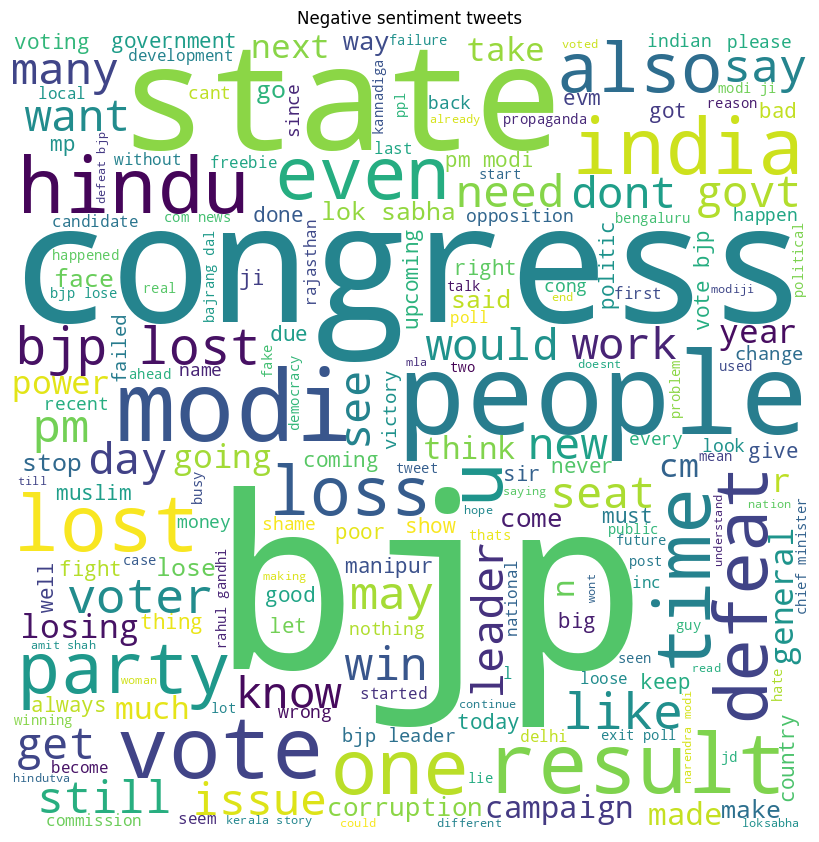

In [360]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import pandas as pd

wordcloud1 = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stop_words,
                min_font_size = 10).generate(cleaned_neg_tweets)
 
# plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud1)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.title('Negative sentiment tweets')
 
plt.show()

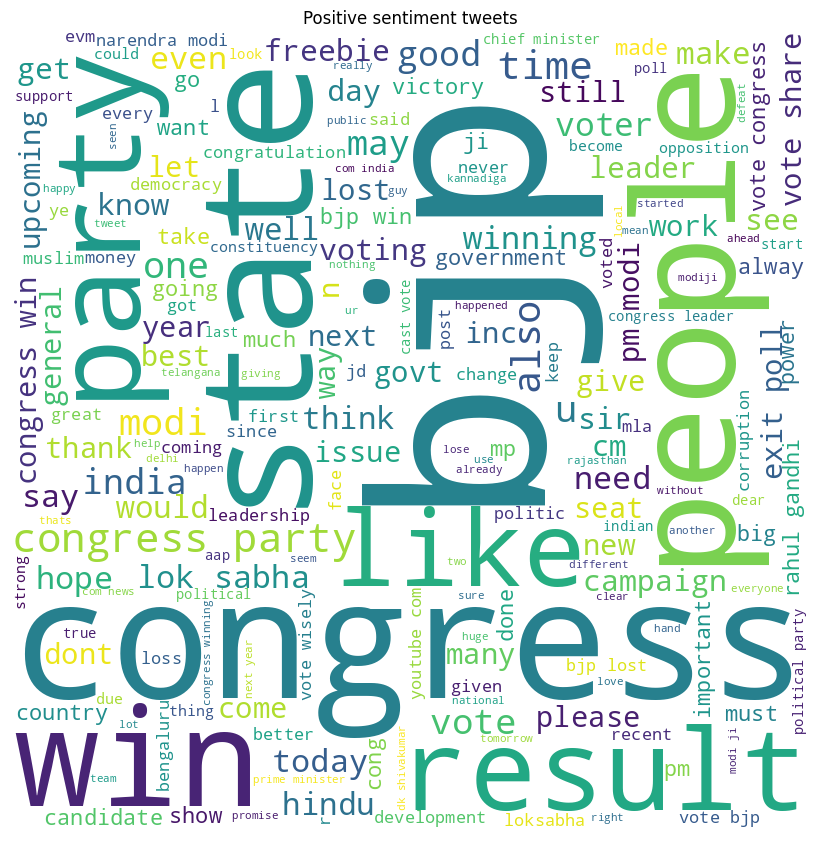

In [361]:
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stop_words,
                min_font_size = 10).generate(cleaned_pos_tweets)
 
# plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.title('Positive sentiment tweets')
 
plt.show()

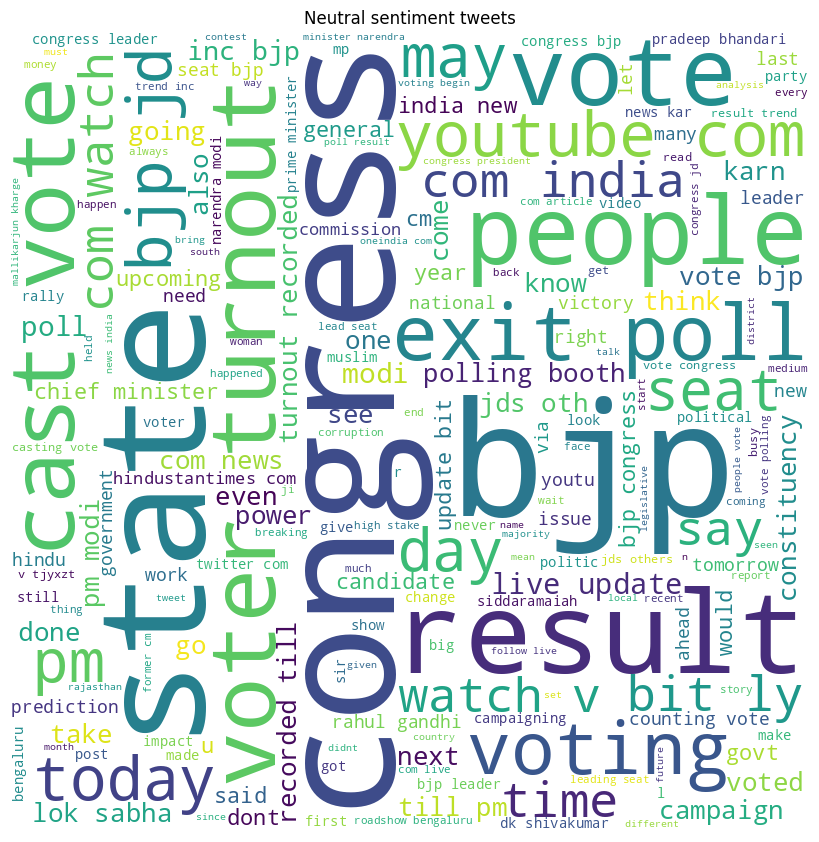

In [362]:
wordcloud3 = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stop_words,
                min_font_size = 10).generate(cleaned_neu_tweets)
 
# plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud3)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.title('Neutral sentiment tweets')
 
plt.show()

## Pie chart based on sentiment

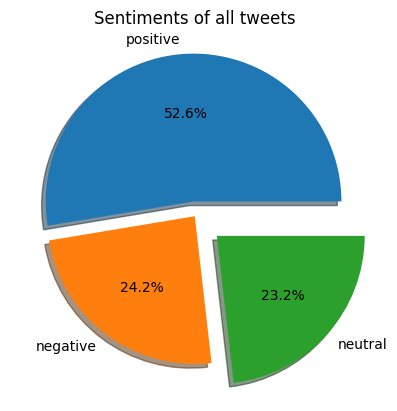

In [6]:
count1 = df_trim['sentiment'].value_counts()
#print(count1)

import matplotlib.pyplot as plt
import numpy as np

y = count1.to_list()
mylabels = count1.keys()
explode = (0.1, 0.0, 0.2)

# Creating autocpt arguments
def func(pct, allvalues):
    absolute = int(pct / 100.*np.sum(allvalues))
    return "{:.1f}%".format(pct, absolute)

plt.pie(y, labels = mylabels,shadow=True, explode=explode, autopct = lambda pct: func(pct, y),
        textprops = dict(color ="black"))
plt.title("Sentiments of all tweets")
plt.show() 

## Bar plots of frequency of words in tweets sentiment wise

In [364]:
positive_tweets =list(df_trim['tweet_rendered_content'].loc[df_trim['sentiment'] == 'positive'])
negative_tweets = list(df_trim['tweet_rendered_content'].loc[df_trim['sentiment'] == 'negative'])
neutral_tweets = list(df_trim['tweet_rendered_content'].loc[df_trim['sentiment'] == 'neutral'])

cleaned_pos_tweets = [extra_clean_tweet(tweet) for tweet in positive_tweets]
cleaned_neg_tweets = [extra_clean_tweet(tweet) for tweet in negative_tweets]
cleaned_neu_tweets = [extra_clean_tweet(tweet) for tweet in neutral_tweets]

cleaned_pos_tweets = ' '.join(cleaned_pos_tweets)
cleaned_neg_tweets = ' '.join(cleaned_neg_tweets)
cleaned_neu_tweets = ' '.join(cleaned_neu_tweets)

<ipython-input-358-c8ce66091bd3>:16: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if type(tweet) == np.float:


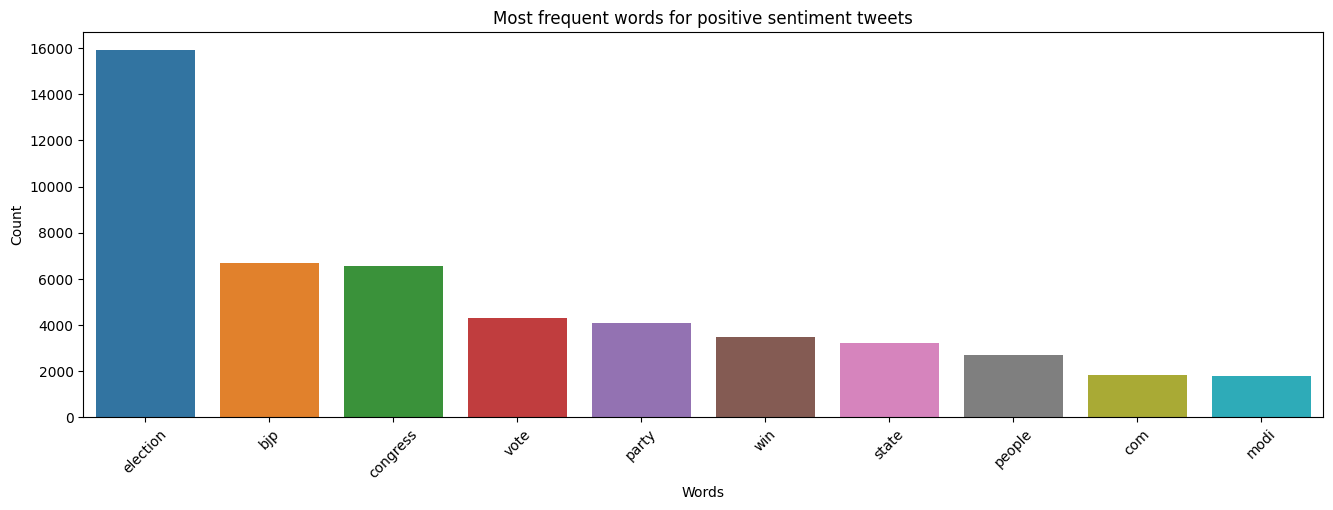

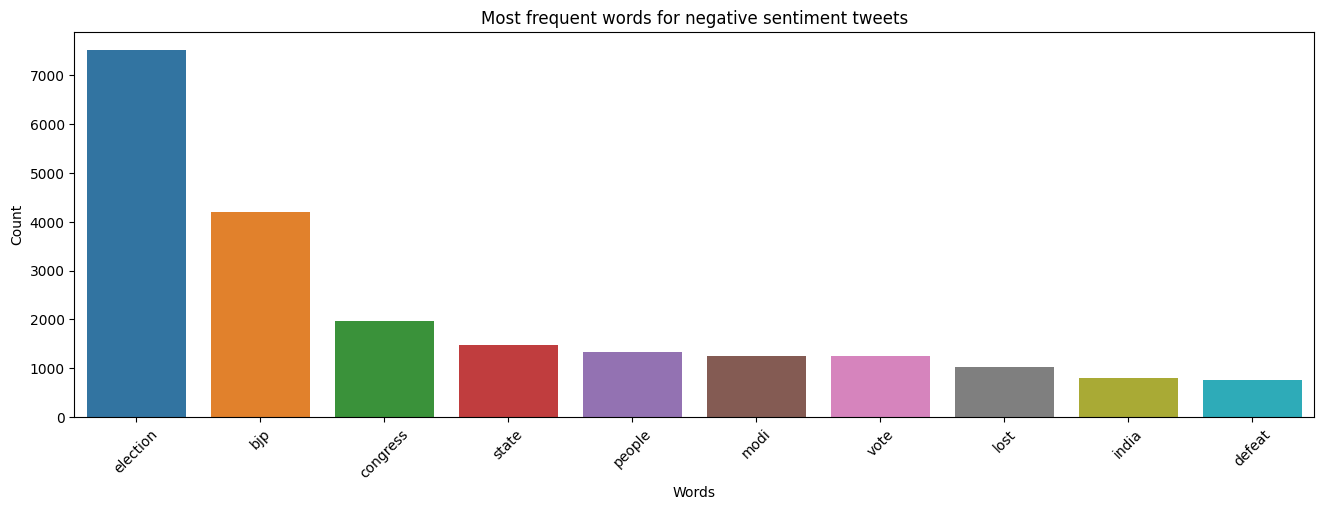

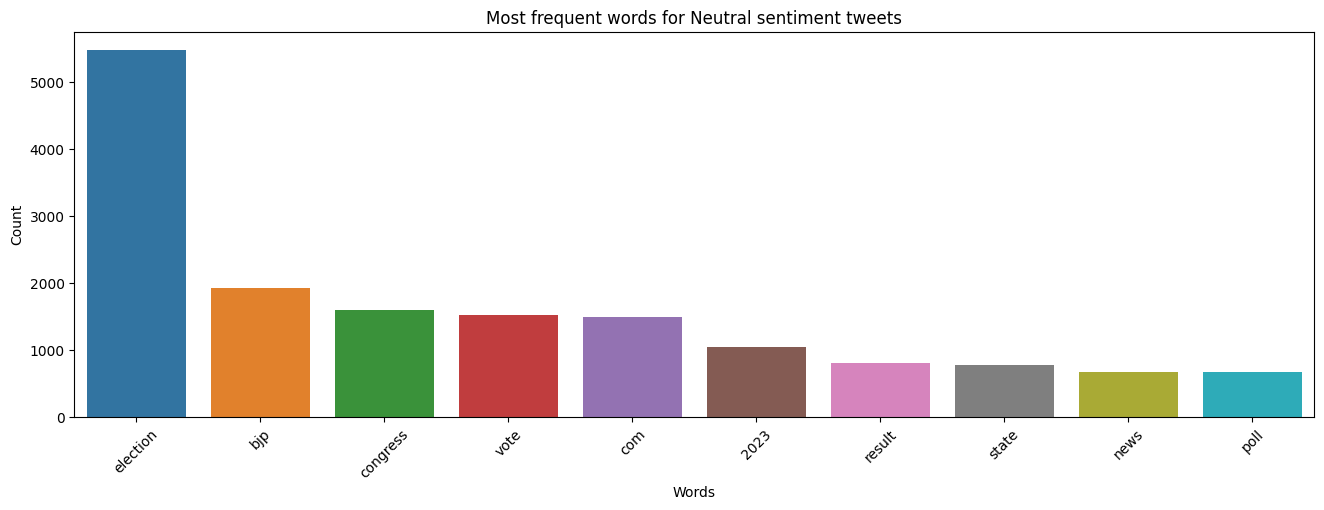

In [365]:
freq_pos_tweets = collections.Counter(cleaned_pos_tweets.split())
graph = pd.DataFrame({'Words': list(freq_pos_tweets.keys()), 'Count': list(freq_pos_tweets.values())})
# Top 10 Most Frequent words in Positive tweets

graph = graph.nlargest(columns="Count", n = 10)
plt.figure(figsize=(16,5))
axis = sns.barplot(data=graph, x="Words", y="Count")
axis.set(ylabel='Count')
plt.xticks(rotation = 45) 
plt.title('Most frequent words for positive sentiment tweets')
plt.show()     

freq_neg_tweets = collections.Counter(cleaned_neg_tweets.split())
graph = pd.DataFrame({'Words': list(freq_neg_tweets.keys()), 'Count': list(freq_neg_tweets.values())})
# Top 10 Most Frequent words in negative tweets

graph = graph.nlargest(columns="Count", n = 10)
plt.figure(figsize=(16,5))
axis = sns.barplot(data=graph, x="Words", y="Count")
axis.set(ylabel='Count')
plt.xticks(rotation = 45) 
plt.title('Most frequent words for negative sentiment tweets')
plt.show()     

freq_neu_tweets = collections.Counter(cleaned_neu_tweets.split())
graph = pd.DataFrame({'Words': list(freq_neu_tweets.keys()), 'Count': list(freq_neu_tweets.values())})
# Top 10 Most Frequent words in neutral tweets

graph = graph.nlargest(columns="Count", n = 10)
plt.figure(figsize=(16,5))
axis = sns.barplot(data=graph, x="Words", y="Count")
axis.set(ylabel='Count')
plt.xticks(rotation = 45) 
plt.title('Most frequent words for Neutral sentiment tweets')
plt.show()     

# Hashtags associated with positive and negative tweets


In [ ]:
positive_hashtags =list(df_trim['tweet_hashtags'].loc[df_trim['sentiment'] == 'positive'])
negative_hashtags = list(df_trim['tweet_hashtags'].loc[df_trim['sentiment'] == 'negative'])
neutral_hashtags = list(df_trim['tweet_hashtags'].loc[df_trim['sentiment'] == 'neutral'])

positive_hashtags = [num for num in positive_hashtags if num!=None]
negative_hashtags = [num for num in negative_hashtags if num!=None]
neutral_hashtags = [num for num in neutral_hashtags if num!=None]

#flattens the list and lowercases it

from functools import reduce
from operator import concat
new_pos_hash = reduce(concat,positive_hashtags)
new_pos_hash = [word.lower() for word in new_pos_hash]

new_neg_hash = reduce(concat,negative_hashtags)
new_neg_hash = [word.lower() for word in new_neg_hash]

new_neu_hash = reduce(concat,neutral_hashtags)
new_neu_hash = [word.lower() for word in new_neu_hash]

import collections
frequency_pos = collections.Counter(new_pos_hash)
frequency_neg = collections.Counter(new_neg_hash)
frequency_neu = collections.Counter(new_neu_hash)
#print(frequency_pos)
#print(frequency_neg)
#print(frequency_neu)



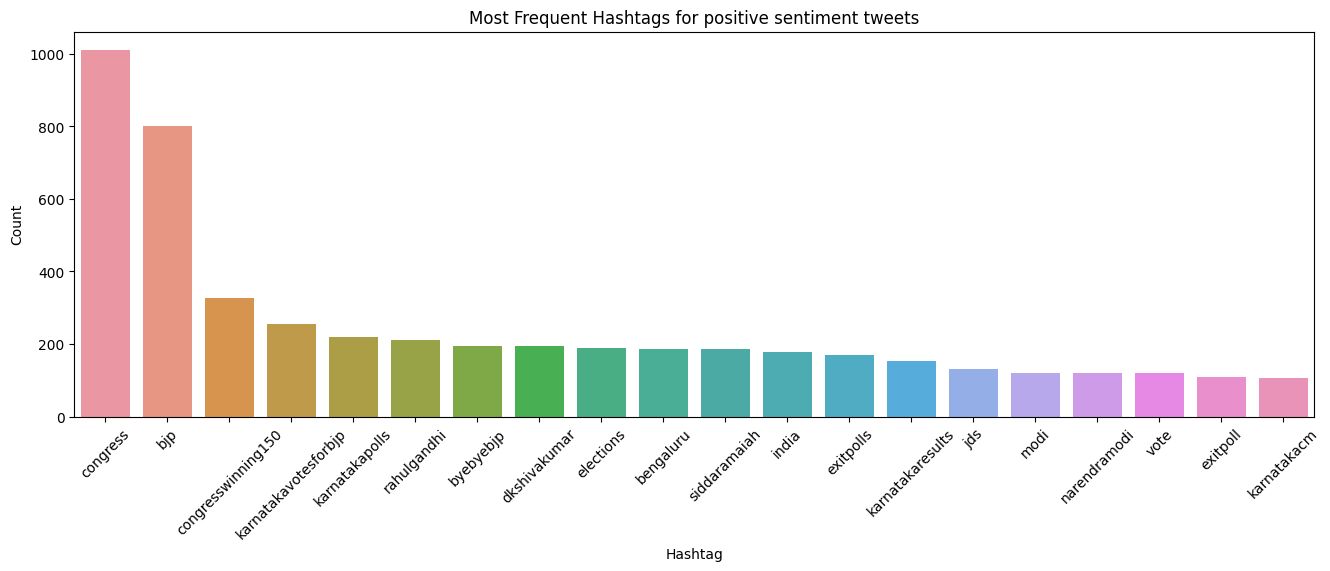

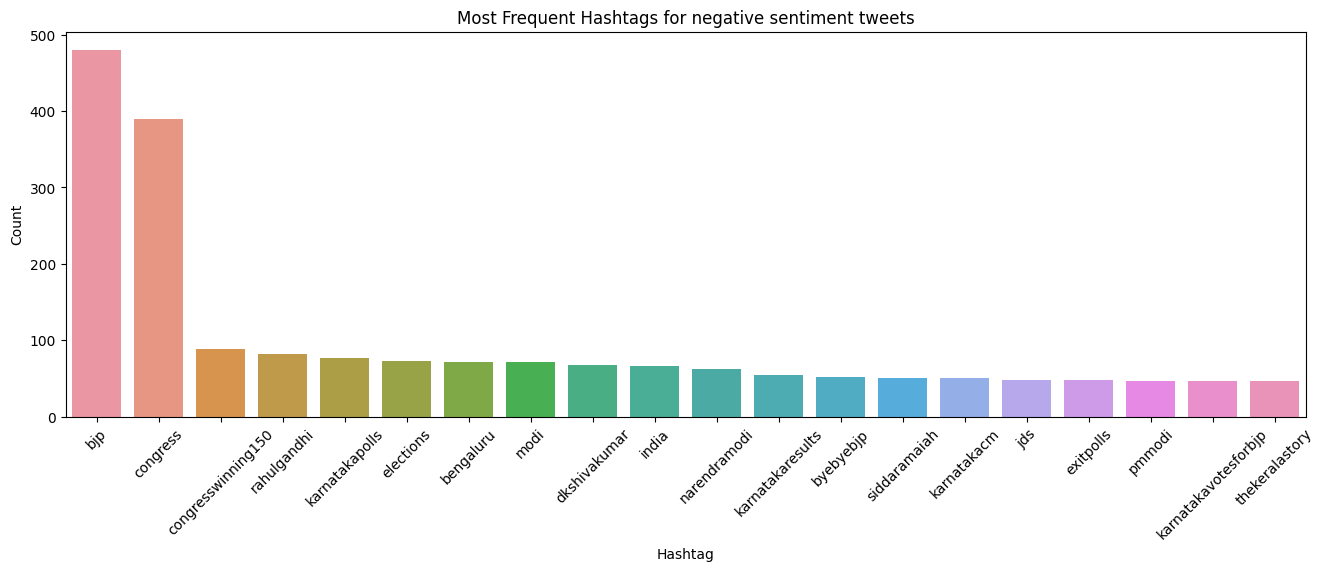

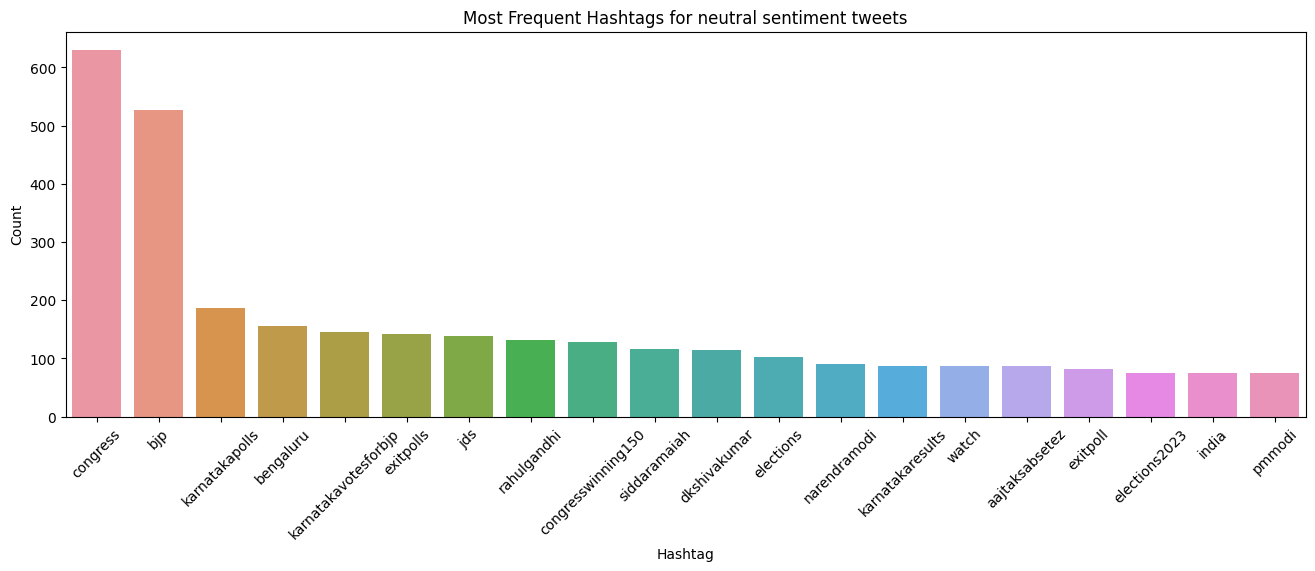

In [367]:
import seaborn as sns

keys_to_remove = ['karnatakaelections','karnataka','karnatakaassemblyelection2023','karnatakaelections2023','karnatakaassemblyelections',
                  'karnatakaassemblyelections2023','karnatakaassemblyelection','karnatakaelection2023','karnatakaelectionresult',
                  'karnatakaelectionresults','karnatakaelectionresults2023','karnatakaelection'] #common terms
new_freq_pos = {key: val for key,val in frequency_pos.items() if key not in keys_to_remove }
graph = pd.DataFrame({'Hashtag': list(new_freq_pos.keys()), 'Count': list(new_freq_pos.values())})

# Top 10 Most Frequent Hashtags in Positive tweets

graph = graph.nlargest(columns="Count", n = 20)
plt.figure(figsize=(16,5))
axis = sns.barplot(data=graph, x="Hashtag", y="Count")
axis.set(ylabel='Count')
plt.xticks(rotation = 45) 
plt.title('Most Frequent Hashtags for positive sentiment tweets')
plt.show()

new_freq_neg = {key: val for key,val in frequency_neg.items() if key not in keys_to_remove }
graph = pd.DataFrame({'Hashtag': list(new_freq_neg.keys()), 'Count': list(new_freq_neg.values())})

# Top 10 Most Frequent Hashtags in negative tweets

graph = graph.nlargest(columns="Count", n = 20)
plt.figure(figsize=(16,5))
axis = sns.barplot(data=graph, x="Hashtag", y="Count")
axis.set(ylabel='Count')
plt.xticks(rotation = 45) 
plt.title('Most Frequent Hashtags for negative sentiment tweets')
plt.show()

new_freq_neu = {key: val for key,val in frequency_neu.items() if key not in keys_to_remove }
graph = pd.DataFrame({'Hashtag': list(new_freq_neu.keys()), 'Count': list(new_freq_neu.values())})

# Top 10 Most Frequent Hashtags in Neutral tweets

graph = graph.nlargest(columns="Count", n = 20)
plt.figure(figsize=(16,5))
axis = sns.barplot(data=graph, x="Hashtag", y="Count")
axis.set(ylabel='Count')
plt.xticks(rotation = 45) 
plt.title('Most Frequent Hashtags for neutral sentiment tweets')
plt.show()     

# Popular influencers and their sentiment scores

In [9]:
## scoring metrics
# 1. post reach = retweets + likes + quotes + replies
# 2. user_influence = followers - friends

reach_cols = ['tweet_retweet_count','tweet_like_count','tweet_quote_count','tweet_reply_count']
df_trim['post_reach'] = df_trim[reach_cols].sum(axis=1)

influencer_cols = ['user_follower_count','user_friend_count']
df_trim['influencer_score'] = df_trim['user_follower_count'] - df_trim['user_friend_count']

In [369]:
df_influencers = df_trim.drop_duplicates('user_name', keep='first')
top_influencers = df_influencers.nlargest(20,'influencer_score')['user_name'].to_list()

In [370]:
score_influencers = []
num_posts = []
for i in range(len(top_influencers)) :
  score_influencers.append(df_trim['sentiment_score'].loc[df_trim['user_name'] == top_influencers[i]].mean(axis=0))
  num_posts.append(len(df_trim['sentiment_score'].loc[df_trim['user_name'] == top_influencers[i]]))

print(score_influencers)
print(num_posts)

[0.8268, 0.128, 0.6145499999999999, -0.5485333333333333, 0.15184464285714286, 0.24117515527950312, 0.5574, 0.1027, 0.28595, 0.24902083333333336, 0.959, 0.0, 0.6073000000000001, 0.16932537313432836, 0.0, 0.26315625, 0.1943778846153846, 0.13168260869565218, 0.029853191489361698, 0.8316]
[1, 1, 2, 3, 56, 161, 1, 1, 2, 96, 1, 2, 3, 201, 1, 32, 104, 138, 47, 1]


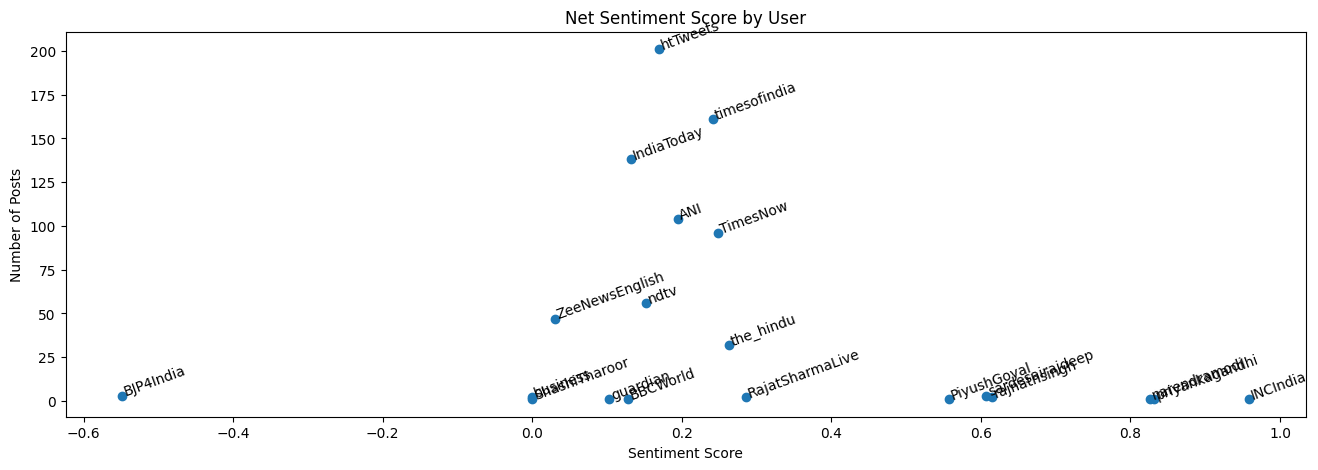

In [371]:
# Bubble chart of net sentiment score by user
# X-axis = sentiment score
# Y-axis = no of records
# bubbles = users

# Sentiment score

colors = np.random.rand(1502)
 
fig, ax = plt.subplots(figsize=(16,5))
ax.scatter(score_influencers, num_posts)
ax.title.set_text('Net Sentiment Score by User')
ax.set_xlabel('Sentiment Score')
ax.set_ylabel('Number of Posts')

#calculating euclidean distance

for i, txt in enumerate(top_influencers):
    ax.annotate(txt, xy=(score_influencers[i], num_posts[i]),rotation=20)
    

plt.show()
#plt.savefig('test.png', bbox_inches="tight")

# Popular 100 posts and their analysis

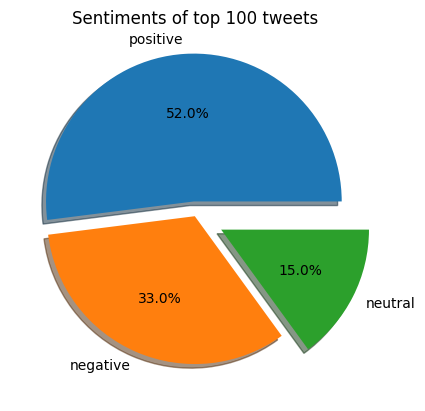

In [10]:
df_popular = df_trim.nlargest(100,'post_reach')
count1 = df_popular['sentiment'].value_counts()
#print(count1)

import matplotlib.pyplot as plt
import numpy as np

y = count1.to_list()
mylabels = count1.keys()
explode = (0.1, 0.0, 0.2)

# Creating autocpt arguments
def func(pct, allvalues):
    absolute = int(pct / 100.*np.sum(allvalues))
    return "{:.1f}%".format(pct, absolute)

plt.pie(y, labels = mylabels,shadow=True, explode=explode, autopct = lambda pct: func(pct, y),
        textprops = dict(color ="black"))
plt.title("Sentiments of top 100 tweets")
plt.show() 

In [373]:
count2 = df_popular['user_name'].value_counts()
count2

ANI               13
rishibagree        6
NewsArenaIndia     3
zoo_bear           3
amitmalviya        2
                  ..
Rajsadasivam74     1
Joydas             1
ShrishtySays       1
ndtv               1
srinivasiyc        1
Name: user_name, Length: 72, dtype: int64

In [375]:
positive_tweets =list(df_popular['tweet_rendered_content'].loc[df_popular['sentiment'] == 'positive'])
negative_tweets = list(df_popular['tweet_rendered_content'].loc[df_popular['sentiment'] == 'negative'])
neutral_tweets = list(df_popular['tweet_rendered_content'].loc[df_popular['sentiment'] == 'neutral'])

cleaned_pos_tweets = [extra_clean_tweet(tweet) for tweet in positive_tweets]
cleaned_neg_tweets = [extra_clean_tweet(tweet) for tweet in negative_tweets]
cleaned_neu_tweets = [extra_clean_tweet(tweet) for tweet in neutral_tweets]

cleaned_pos_tweets = ' '.join(cleaned_pos_tweets)
cleaned_neg_tweets = ' '.join(cleaned_neg_tweets)
cleaned_neu_tweets = ' '.join(cleaned_neu_tweets)

<ipython-input-358-c8ce66091bd3>:16: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if type(tweet) == np.float:


## Drawing wordclouds sentiment wise

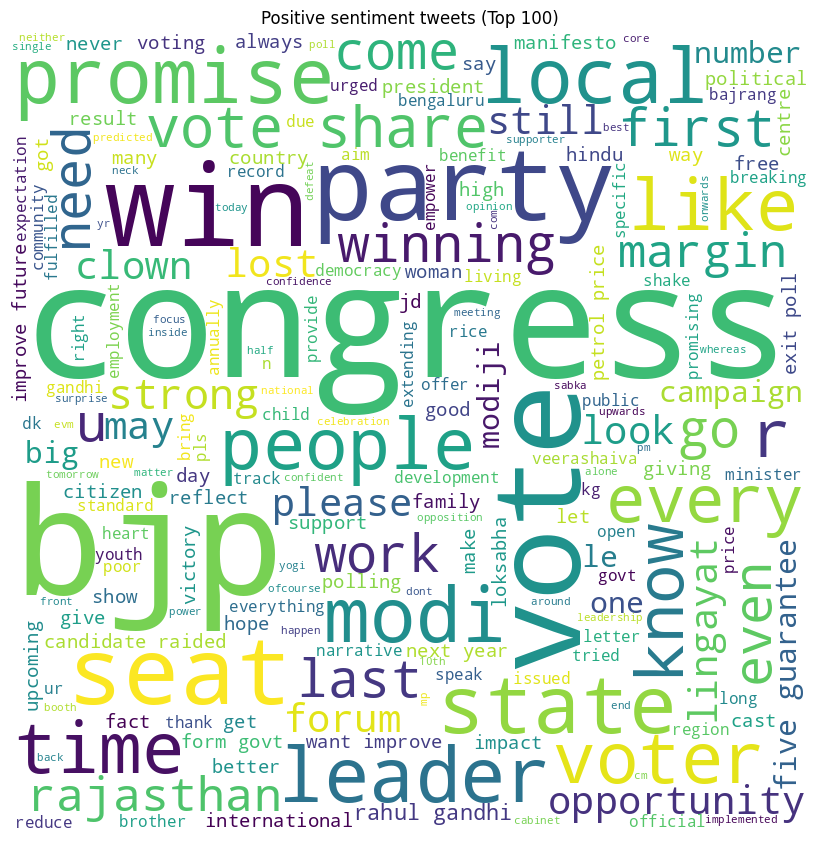

In [384]:
wordcloud1 = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stop_words,
                min_font_size = 10).generate(cleaned_pos_tweets)
 
# plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud1)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.title('Positive sentiment tweets (Top 100)')
 
plt.show()

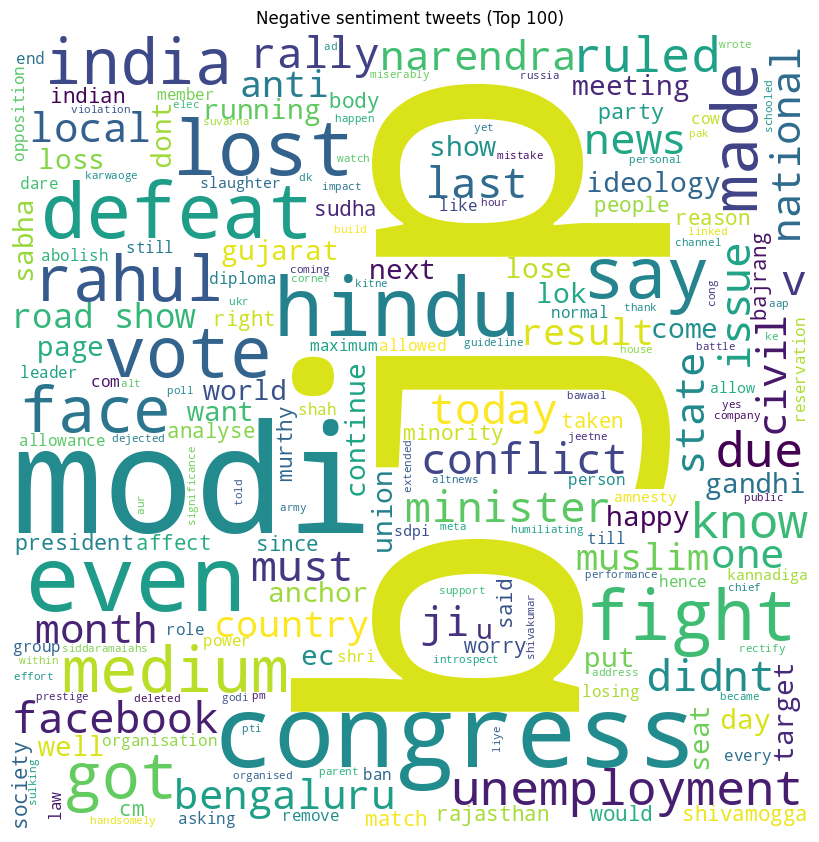

In [385]:
wordcloud2 = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stop_words,
                min_font_size = 10).generate(cleaned_neg_tweets)
 
# plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud2)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.title('Negative sentiment tweets (Top 100)')
 
plt.show()

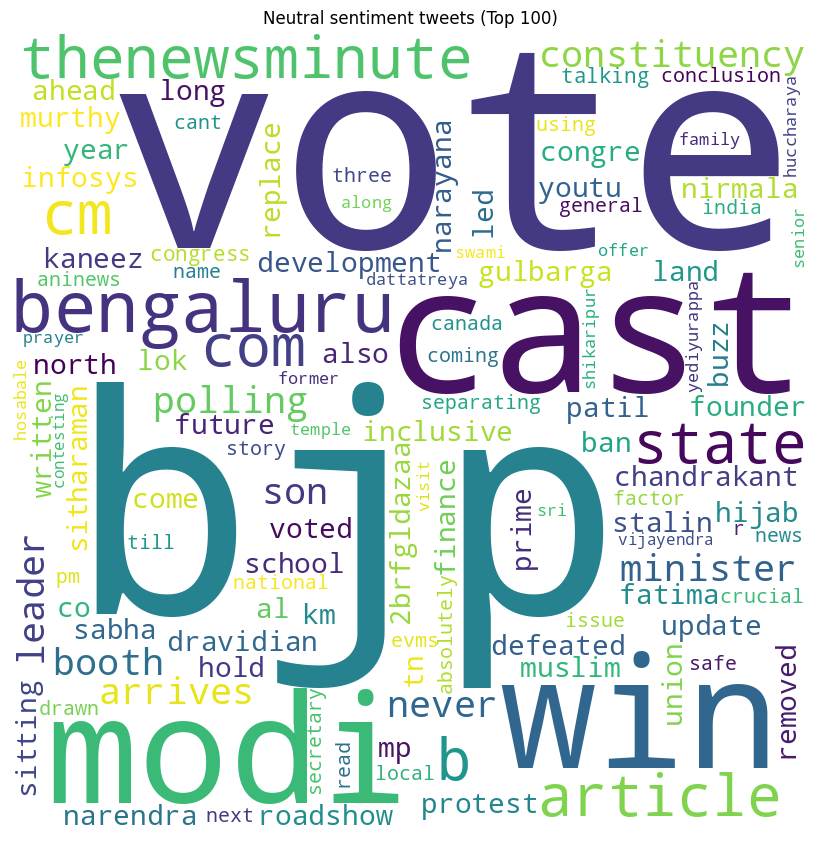

In [386]:
wordcloud3 = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stop_words,
                min_font_size = 10).generate(cleaned_neu_tweets)
 
# plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud3)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.title('Neutral sentiment tweets (Top 100)')
 
plt.show()

## Drawing barplots 

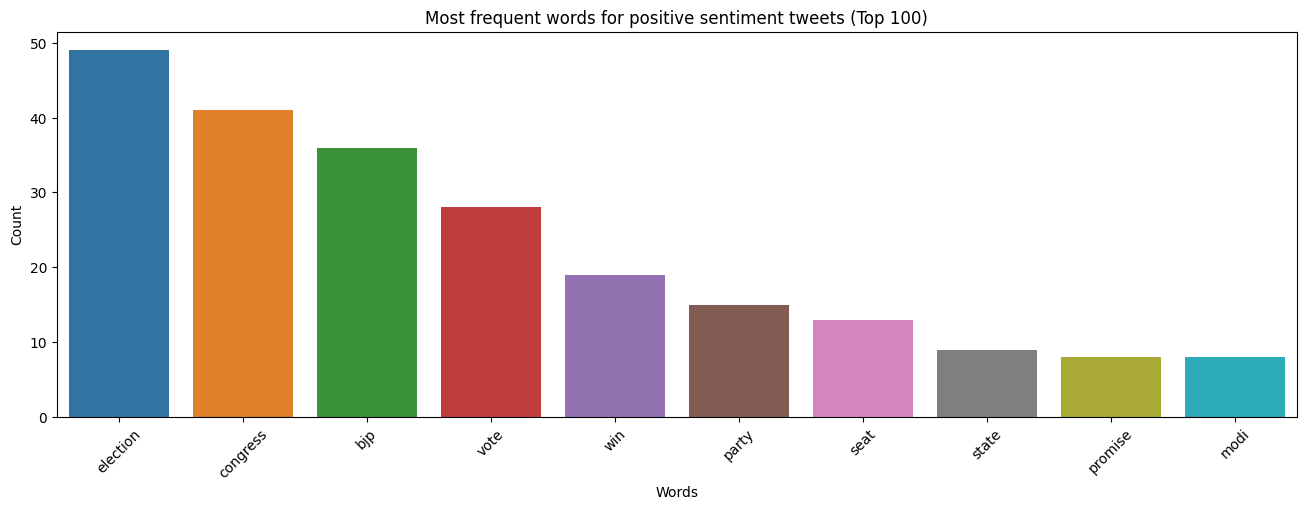

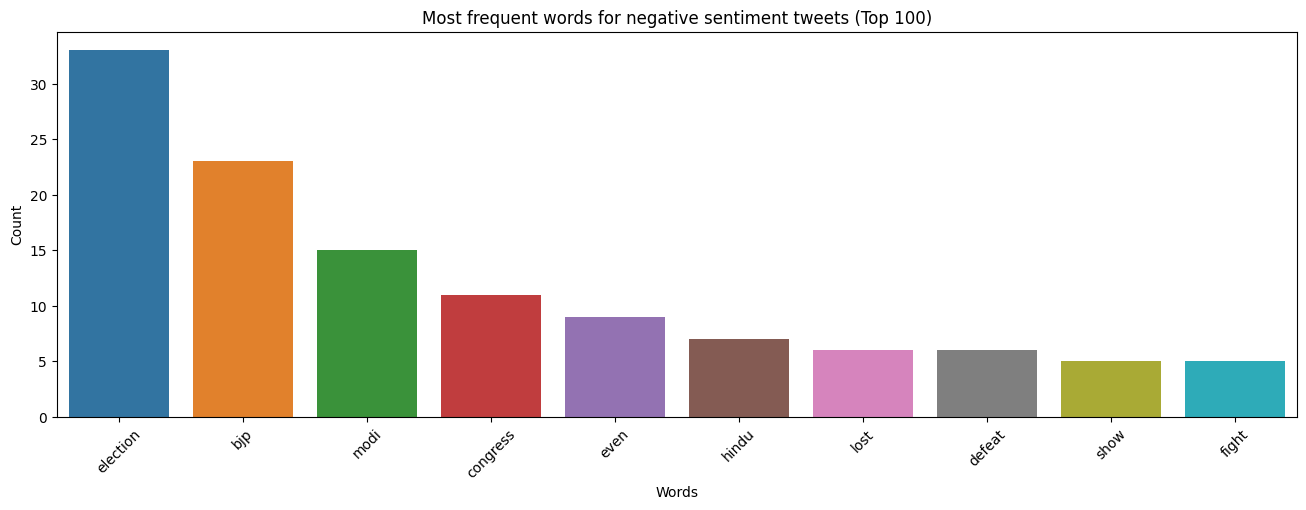

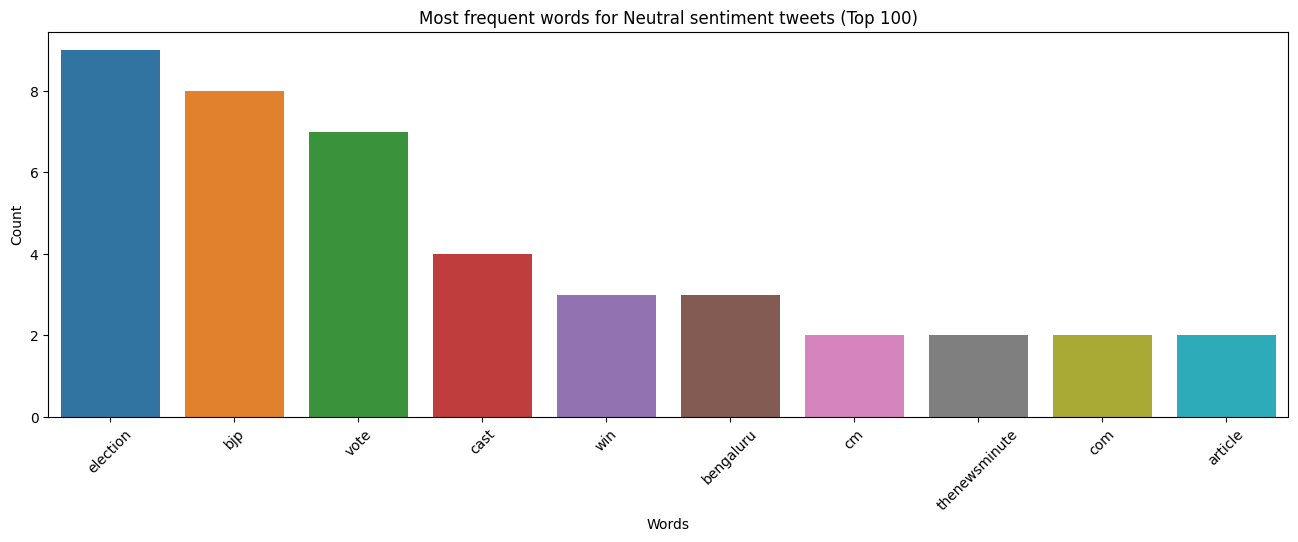

In [387]:
freq_pos_tweets = collections.Counter(cleaned_pos_tweets.split())
graph = pd.DataFrame({'Words': list(freq_pos_tweets.keys()), 'Count': list(freq_pos_tweets.values())})
# Top 10 Most Frequent words in Positive tweets

graph = graph.nlargest(columns="Count", n = 10)
plt.figure(figsize=(16,5))
axis = sns.barplot(data=graph, x="Words", y="Count")
axis.set(ylabel='Count')
plt.xticks(rotation = 45) 
plt.title('Most frequent words for positive sentiment tweets (Top 100)')
plt.show()     

freq_neg_tweets = collections.Counter(cleaned_neg_tweets.split())
graph = pd.DataFrame({'Words': list(freq_neg_tweets.keys()), 'Count': list(freq_neg_tweets.values())})
# Top 10 Most Frequent words in negative tweets

graph = graph.nlargest(columns="Count", n = 10)
plt.figure(figsize=(16,5))
axis = sns.barplot(data=graph, x="Words", y="Count")
axis.set(ylabel='Count')
plt.xticks(rotation = 45) 
plt.title('Most frequent words for negative sentiment tweets (Top 100)')
plt.show()     

freq_neu_tweets = collections.Counter(cleaned_neu_tweets.split())
graph = pd.DataFrame({'Words': list(freq_neu_tweets.keys()), 'Count': list(freq_neu_tweets.values())})
# Top 10 Most Frequent words in neutral tweets

graph = graph.nlargest(columns="Count", n = 10)
plt.figure(figsize=(16,5))
axis = sns.barplot(data=graph, x="Words", y="Count")
axis.set(ylabel='Count')
plt.xticks(rotation = 45) 
plt.title('Most frequent words for Neutral sentiment tweets (Top 100)')
plt.show()     

# Mentions of particular words (bjp and congress) & (modi and rahulgandhi) across time

In [380]:
df_date = pd.to_datetime(df_trim['date'])
df_trim['Day_only'] = df_date.dt.date
dates = list(df_trim['Day_only'].unique())

<ipython-input-380-f71566141a49>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_trim['Day_only'] = df_date.dt.date


In [389]:
bjp_counts = []
congress_counts = []
rahul_counts = []
modi_counts = []

for i in dates :
  temp = ' '.join(list(df_trim['tweet_rendered_content'].loc[df_trim['Day_only'] == i]))
  cleaned_temp = extra_clean_tweet(temp)
  bjp_counts.append(cleaned_temp.split().count('bjp'))
  congress_counts.append(cleaned_temp.split().count('congress'))
  rahul_counts.append(cleaned_temp.split().count('rahul'))
  modi_counts.append(cleaned_temp.split().count('modi'))
  
bjp_dict = {dates[i]: bjp_counts[i] for i in range(len(dates))}
congress_dict = {dates[i]: congress_counts[i] for i in range(len(dates))}
rahul_dict = {dates[i]: rahul_counts[i] for i in range(len(dates))}
modi_dict = {dates[i]: modi_counts[i] for i in range(len(dates))}

<ipython-input-358-c8ce66091bd3>:16: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if type(tweet) == np.float:


Text(0, 0.5, 'Counts')

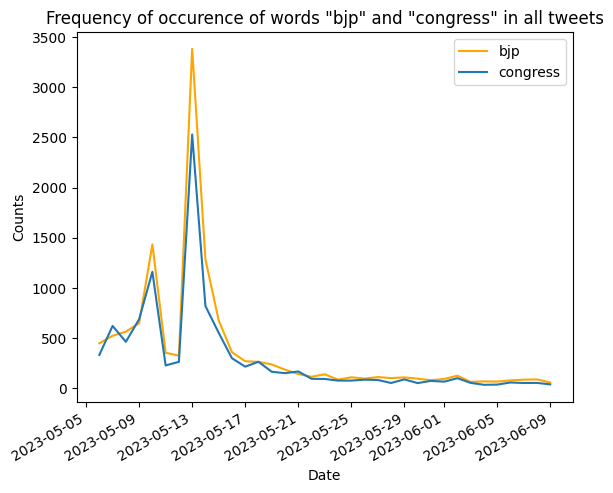

In [390]:
# import modules
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import numpy as np
 
# Plotting the time series of given dataframe
plt.plot(bjp_dict.keys(), bjp_dict.values(), color='orange')

plt.plot(congress_dict.keys(), congress_dict.values())
 
# Giving title to the chart using plt.title
plt.title('Frequency of occurence of words "bjp" and "congress" in all tweets')
 
# rotating the x-axis tick labels at 30degree
# towards right
plt.xticks(rotation=30, ha='right')
plt.legend(["bjp", "congress"], loc ="upper right")

# Providing x and y label to the chart
plt.xlabel('Date')
plt.ylabel('Counts')

Text(0, 0.5, 'Counts')

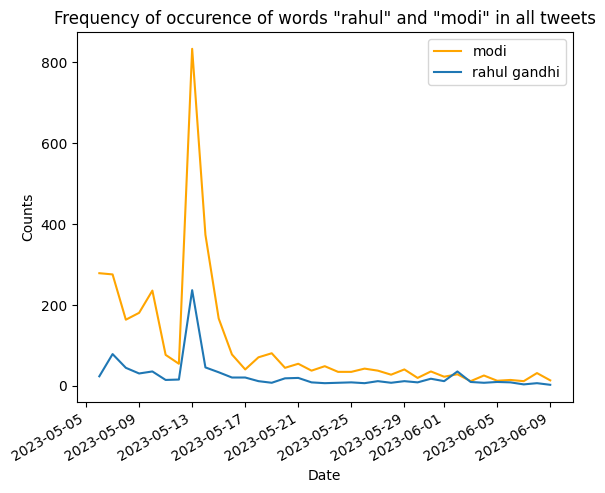

In [391]:
# Plotting the time series of given dataframe
plt.plot(modi_dict.keys(), modi_dict.values(), color='orange')

plt.plot(rahul_dict.keys(), rahul_dict.values())
 
# Giving title to the chart using plt.title
plt.title('Frequency of occurence of words "rahul" and "modi" in all tweets')
 
# rotating the x-axis tick labels at 30degree
# towards right
plt.xticks(rotation=30, ha='right')
plt.legend(["modi", "rahul gandhi"], loc ="upper right")

# Providing x and y label to the chart
plt.xlabel('Date')
plt.ylabel('Counts')

## For positive tweets

In [392]:
rahul_counts = []
modi_counts = []
bjp_counts = []
congress_counts = []

for i in dates :
  temp = ' '.join(list(df_trim['tweet_rendered_content'].loc[(df_trim['Day_only'] == i) & (df_trim['sentiment'] == 'positive')]))
  cleaned_temp = extra_clean_tweet(temp)
  bjp_counts.append(cleaned_temp.split().count('bjp'))
  congress_counts.append(cleaned_temp.split().count('congress'))
  rahul_counts.append(cleaned_temp.split().count('rahul'))
  modi_counts.append(cleaned_temp.split().count('modi'))
  
bjp_dict = {dates[i]: bjp_counts[i] for i in range(len(dates))}
congress_dict = {dates[i]: congress_counts[i] for i in range(len(dates))}
rahul_dict = {dates[i]: rahul_counts[i] for i in range(len(dates))}
modi_dict = {dates[i]: modi_counts[i] for i in range(len(dates))}


<ipython-input-358-c8ce66091bd3>:16: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if type(tweet) == np.float:


Text(0, 0.5, 'Counts')

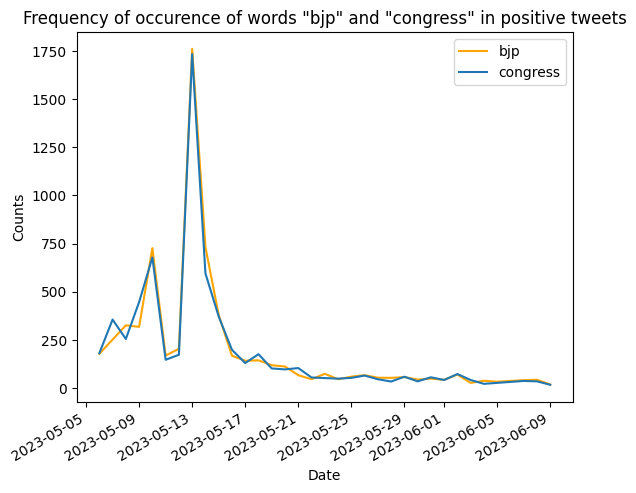

In [393]:
# import modules
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import numpy as np
 
# Plotting the time series of given dataframe
plt.plot(bjp_dict.keys(), bjp_dict.values(), color='orange')

plt.plot(congress_dict.keys(), congress_dict.values())
 
# Giving title to the chart using plt.title
plt.title('Frequency of occurence of words "bjp" and "congress" in positive tweets')
 
# rotating the x-axis tick labels at 30degree
# towards right
plt.xticks(rotation=30, ha='right')
plt.legend(["bjp", "congress"], loc ="upper right")

# Providing x and y label to the chart
plt.xlabel('Date')
plt.ylabel('Counts')

Text(0, 0.5, 'Counts')

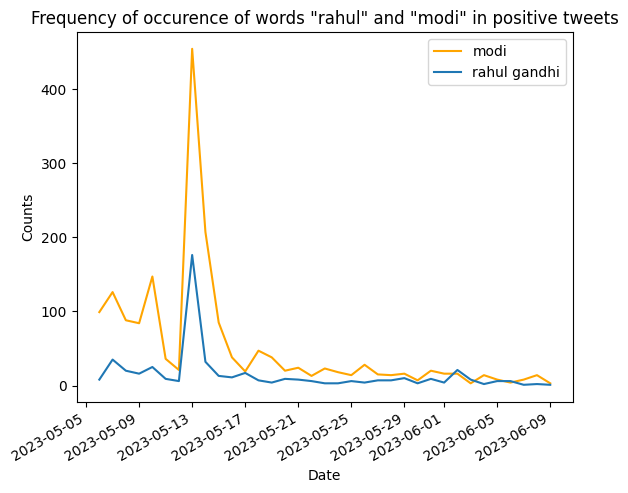

In [394]:
# Plotting the time series of given dataframe
plt.plot(modi_dict.keys(), modi_dict.values(), color='orange')

plt.plot(rahul_dict.keys(), rahul_dict.values())
 
# Giving title to the chart using plt.title
plt.title('Frequency of occurence of words "rahul" and "modi" in positive tweets')
 
# rotating the x-axis tick labels at 30degree
# towards right
plt.xticks(rotation=30, ha='right')
plt.legend(["modi", "rahul gandhi"], loc ="upper right")

# Providing x and y label to the chart
plt.xlabel('Date')
plt.ylabel('Counts')

## For negative tweets

In [395]:
rahul_counts = []
modi_counts = []
bjp_counts = []
congress_counts = []

for i in dates :
  temp = ' '.join(list(df_trim['tweet_rendered_content'].loc[(df_trim['Day_only'] == i) & (df_trim['sentiment'] == 'negative')]))
  cleaned_temp = extra_clean_tweet(temp)
  bjp_counts.append(cleaned_temp.split().count('bjp'))
  congress_counts.append(cleaned_temp.split().count('congress'))
  rahul_counts.append(cleaned_temp.split().count('rahul'))
  modi_counts.append(cleaned_temp.split().count('modi'))
  
bjp_dict = {dates[i]: bjp_counts[i] for i in range(len(dates))}
congress_dict = {dates[i]: congress_counts[i] for i in range(len(dates))}
rahul_dict = {dates[i]: rahul_counts[i] for i in range(len(dates))}
modi_dict = {dates[i]: modi_counts[i] for i in range(len(dates))}


<ipython-input-358-c8ce66091bd3>:16: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if type(tweet) == np.float:


Text(0, 0.5, 'Counts')

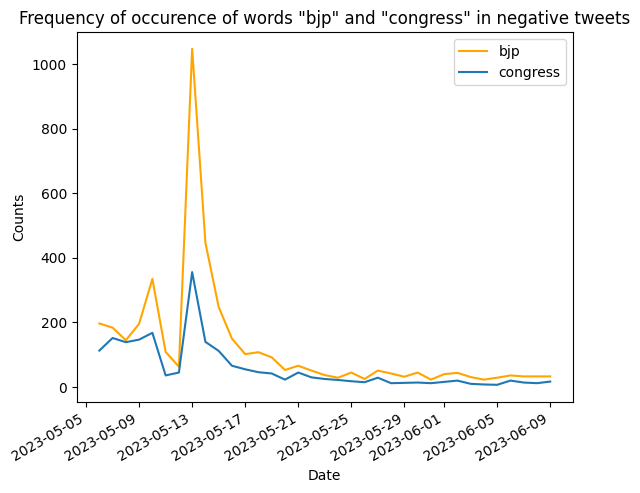

In [396]:
# import modules
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import numpy as np
 
# Plotting the time series of given dataframe
plt.plot(bjp_dict.keys(), bjp_dict.values(), color='orange')

plt.plot(congress_dict.keys(), congress_dict.values())
 
# Giving title to the chart using plt.title
plt.title('Frequency of occurence of words "bjp" and "congress" in negative tweets')
 
# rotating the x-axis tick labels at 30degree
# towards right
plt.xticks(rotation=30, ha='right')
plt.legend(["bjp", "congress"], loc ="upper right")

# Providing x and y label to the chart
plt.xlabel('Date')
plt.ylabel('Counts')

Text(0, 0.5, 'Counts')

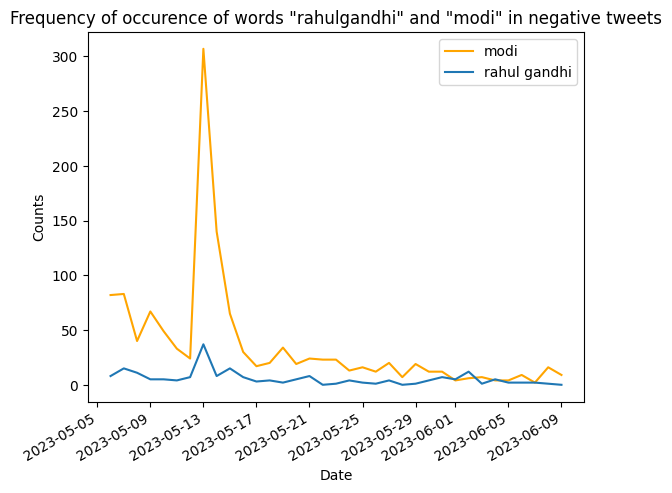

In [397]:
# Plotting the time series of given dataframe
plt.plot(modi_dict.keys(), modi_dict.values(), color='orange')

plt.plot(rahul_dict.keys(), rahul_dict.values())
 
# Giving title to the chart using plt.title
plt.title('Frequency of occurence of words "rahulgandhi" and "modi" in negative tweets')
 
# rotating the x-axis tick labels at 30degree
# towards right
plt.xticks(rotation=30, ha='right')
plt.legend(["modi", "rahul gandhi"], loc ="upper right")

# Providing x and y label to the chart
plt.xlabel('Date')
plt.ylabel('Counts')